In [126]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
from b3d import Pose
from b3d import Mesh, Pose
from b3d.pose import Pose, camera_from_position_and_target
from scipy.spatial import transform
import h5py
import matplotlib.pyplot as plt
import b3d.utils as utils
genjax.pretty()

In [127]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

hdf5_file_path = os.path.join(physion_assets_path,
    "hdf5s/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0012.hdf5",
)

In [135]:
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        if key == '0000':
            position = jnp.array(f['frames'][key]['objects']['positions_cam0'])
            rotation = jnp.array(f['frames'][key]['objects']['rotations_cam0'])
rotation

<jax.Array float32(5, 4) ≈0.27 ±0.42 [≥-0.033, ≤1.0] zero:7 nonzero:13
  <Arrayviz rendering>
>

In [138]:
euler_angles_to_quaternion(object_initial_rotations[2])

array([0.        , 0.10117607, 0.        , 0.99486854])

In [136]:
position

<jax.Array float32(5, 3) ≈0.042 ±0.45 [≥-1.0, ≤0.92] zero:4 nonzero:11
  <Arrayviz rendering>
>

In [150]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0010']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))
  
    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    distractors = np.array(f['static']['distractors'])
    occluders = np.array(f['static']['occluders'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
    meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]

In [181]:
swap = np.array([[1,0,0],[0,0,1],[0,1,0]])
# rot = np.array([[1, 0, 0],
#                 [0, -1, 0],
#                 [0, 0, -1]])
# swap_rot = np.dot(rot, swap)
cam_r = np.transpose(R @ jnp.linalg.inv(swap))
cam_r_new = np.transpose(np.array([cam_r[:,0],-cam_r[:,1],-cam_r[:,2]]))
print(cam_r_new)

[[-0.87257326 -0.329855    0.36029425]
 [-0.48848364  0.5892165  -0.64359   ]
 [ 0.         -0.7375769  -0.67526317]]


In [180]:
print(cam_r[:,0])

[-0.87257326 -0.48848364  0.        ]


In [4]:
# camera_azimuth

In [5]:
# projection_matrix

In [6]:
# camera_matrix_old = camera_matrix
# camera_matrix_old

In [6]:
# rot = np.array([[1, 0, 0, 0],
#                 [0, -1, 0, 0],
#                 [0, 0, -1, 0],
#                 [0, 0, 0, 1]])
# camera_matrix = np.dot(camera_matrix, rot)
# camera_matrix

In [129]:
camera_matrix

array([[-8.7257326e-01,  0.0000000e+00, -4.8848364e-01, -1.7881393e-07],
       [ 3.2985500e-01,  7.3757690e-01, -5.8921647e-01,  2.9802322e-08],
       [-3.6029425e-01,  6.7526317e-01,  6.4358997e-01, -2.3322058e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [107]:
R = camera_matrix[0:3, 0:3]
R

array([[-0.87257326,  0.        , -0.48848364],
       [ 0.329855  ,  0.7375769 , -0.5892165 ],
       [-0.36029425,  0.67526317,  0.64359   ]], dtype=float32)

In [108]:
quat_sp = transform.Rotation.from_matrix(R).as_quat()
quat_sp

array([ 0.1649275 ,  0.98328011,  0.04302335, -0.06409469])

In [109]:
T = camera_matrix[0:3, 3]
T

array([-1.7881393e-07,  2.9802322e-08, -2.3322058e+00], dtype=float32)

In [142]:

C

array([-0.8402802,  1.5748523,  1.5009834], dtype=float32)

In [182]:
camera_matrix
a = np.array([-R[0,:], -R[1,:], -R[2,:]])
b = np.array(T)
camera_position_from_matrix = np.linalg.solve(a, b)
# print(camera_position_from_matrix)
# print(camera)
R = camera_matrix[:3,:3]
new_camera_pose = Pose(
    camera_position_from_matrix,
    # b3d.Rot.from_matrix(jnp.linalg.inv(R)).as_quat()
    b3d.Rot.from_matrix(cam_r_new).as_quat()
)
new_camera_pose

Pose(position=array([-0.8402802,  1.5748523,  1.5009834], dtype=float32), quaternion=Array([-0.23101601,  0.8855863 , -0.3899018 ,  0.10171064], dtype=float32))

In [147]:
print(R)

[[-0.87257326  0.         -0.48848364]
 [ 0.329855    0.7375769  -0.5892165 ]
 [-0.36029425  0.67526317  0.64359   ]]


In [148]:
print(new_camera_pose.as_matrix())

[[-0.93738174  0.32985502 -0.11185462 -0.8402802 ]
 [ 0.31882477  0.94189596  0.10574998  1.5748523 ]
 [ 0.14023755  0.06346606 -0.9880818   1.5009834 ]
 [ 0.          0.          0.          1.        ]]


In [149]:
print(camera_pose.as_matrix())

[[-8.8226956e-01 -3.0296654e-01  3.6029434e-01 -8.4028018e-01]
 [-4.7074491e-01  5.6781954e-01 -6.7526335e-01  1.5748523e+00]
 [ 1.4901161e-08 -7.6537091e-01 -6.4358968e-01  1.5009834e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [11]:
# test decomposition
pw = np.array([1, 2, 3])
pc1 = R.dot(pw)+T
pc2 = camera_matrix.dot(np.append(pw,[1]))
assert np.array_equal(pc1, pc2[:3])

In [13]:
camera_pose = Pose(jnp.asarray(C), jnp.asarray(quat_sp))
camera_pose

Pose(position=Array([-0.8402802,  1.5748523,  1.5009834], dtype=float32), quaternion=Array([ 0.1649275 ,  0.9832801 ,  0.04302335, -0.06409469], dtype=float32))

In [14]:
object_ids, model_names, distractors, occluders

(array([1, 2, 3, 4, 5]),
 array([b'cube', b'cube', b'cube', b'chair_thonet_marshall', b'vase_03'],
       dtype=object),
 array([b'chair_thonet_marshall'], dtype=object),
 array([b'vase_03'], dtype=object))

In [15]:
for i in initial_position:
    print(i)

[0.85 0.   0.  ]
[0.25 0.   0.  ]
[-0.25  0.    0.  ]
[ 0.37436676  0.         -1.        ]
[-0.51430506  0.          0.91869754]


In [16]:
for i in initial_rotation:
    print(i)

[0. 0. 0.]
[0. 0. 0.]
[ 0.       11.613795  0.      ]
[ 0.        -3.7296226  0.       ]
[  0.      113.39555   0.     ]


In [17]:
for i in scales:
    print(i)

[0.5  0.01 2.  ]
[0.1  0.5  0.25]
[0.1       0.4793447 0.2752273]
[1. 1. 1.]
[2.3146927 2.3146927 2.3146927]


In [18]:
for i in meshes_faces:
    print(i)

[[ 0  1  2]
 [ 3  1  0]
 [ 3  4  1]
 [ 5  3  0]
 [ 6  4  3]
 [ 6  7  4]
 [ 6  8  7]
 [ 9  3  5]
 [ 9  6  3]
 [10  9  5]
 [10 11  9]
 [12  8  6]
 [ 9 12  6]
 [11 12  9]
 [12 13  8]
 [11 14 12]
 [14 13 12]
 [14 15 13]
 [16 17 18]
 [19 17 16]
 [19 20 17]
 [21 19 16]
 [22 20 19]
 [22 23 20]
 [22 24 23]
 [25 19 21]
 [25 22 19]
 [26 25 21]
 [26 27 25]
 [28 24 22]
 [25 28 22]
 [27 28 25]
 [28 29 24]
 [27 30 28]
 [30 29 28]
 [30 31 29]
 [32 33 34]
 [35 33 32]
 [35 36 33]
 [37 35 32]
 [38 36 35]
 [38 39 36]
 [38 40 39]
 [41 35 37]
 [41 38 35]
 [42 41 37]
 [42 43 41]
 [44 40 38]
 [41 44 38]
 [43 44 41]
 [44 45 40]
 [43 46 44]
 [46 45 44]
 [46 47 45]
 [48 49 50]
 [51 49 48]
 [51 52 49]
 [53 51 48]
 [54 52 51]
 [54 55 52]
 [54 56 55]
 [57 51 53]
 [57 54 51]
 [58 57 53]
 [58 59 57]
 [60 56 54]
 [57 60 54]
 [59 60 57]
 [60 61 56]
 [59 62 60]
 [62 61 60]
 [62 63 61]
 [64 65 66]
 [67 65 64]
 [67 68 65]
 [69 67 64]
 [70 68 67]
 [70 71 68]
 [70 72 71]
 [73 67 69]
 [73 70 67]
 [74 73 69]
 [74 75 73]
 [76

In [19]:
for i in meshes_vertices:
    print(i.shape)

(96, 3)
(96, 3)
(96, 3)
(20370, 3)
(2587, 3)


In [20]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    vertices[:,[2,1]] = vertices[:,[1,2]]
    return vertices

In [21]:
excluded_model_ids = np.concatenate((np.where(model_names==distractors), np.where(model_names==occluders)), axis=0)
included_model_names = [model_names[idx] for idx in range(len(object_ids)) if idx not in excluded_model_ids]
included_model_ids = [object_ids[idx]-1 for idx in range(len(object_ids)) if idx not in excluded_model_ids]


In [22]:
excluded_model_ids, included_model_names, included_model_ids

(array([[3],
        [4]]),
 [b'cube', b'cube', b'cube'],
 [0, 1, 2])

In [23]:
object_initial_positions = [np.array([pos[0],pos[2],pos[1]]) for idx, pos in enumerate(initial_position) if idx in included_model_ids]
object_initial_rotations = [rot for idx, rot in enumerate(initial_rotation) if idx in included_model_ids]
object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
# object_meshes = [(vertex, face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]
object_meshes = [(scale_mesh(vertex, object_scales[idx]), face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]


In [24]:
for i in object_initial_positions:
    print(i)

[0.85 0.   0.  ]
[0.25 0.   0.  ]
[-0.25  0.    0.  ]


In [25]:
for i in object_initial_rotations:
    print(i)

[0. 0. 0.]
[0. 0. 0.]
[ 0.       11.613795  0.      ]


In [26]:
for i in object_scales:
    print(i)

[0.5  0.01 2.  ]
[0.1  0.5  0.25]
[0.1       0.4793447 0.2752273]


In [27]:
for i in object_meshes:
    print(i)

(array([[ 0.25      ,  0.333334  ,  0.01      ],
       [ 0.0833335 ,  1.        ,  0.01      ],
       [ 0.25      ,  1.        ,  0.01      ],
       [ 0.0833335 ,  0.333334  ,  0.01      ],
       [-0.0833335 ,  1.        ,  0.01      ],
       [ 0.25      , -0.333334  ,  0.01      ],
       [-0.0833335 ,  0.333334  ,  0.01      ],
       [-0.25      ,  1.        ,  0.01      ],
       [-0.25      ,  0.333334  ,  0.01      ],
       [ 0.0833335 , -0.333334  ,  0.01      ],
       [ 0.25      , -1.        ,  0.01      ],
       [ 0.0833335 , -1.        ,  0.01      ],
       [-0.0833335 , -0.333334  ,  0.01      ],
       [-0.25      , -0.333334  ,  0.01      ],
       [-0.0833335 , -1.        ,  0.01      ],
       [-0.25      , -1.        ,  0.01      ],
       [-0.25      ,  0.333334  ,  0.        ],
       [-0.0833335 ,  1.        ,  0.        ],
       [-0.25      ,  1.        ,  0.        ],
       [-0.0833335 ,  0.333334  ,  0.        ],
       [ 0.0833335 ,  1.        ,  0.  

In [28]:
for vertices, faces in object_meshes:
    print(vertices.shape)

(96, 3)
(96, 3)
(96, 3)


In [29]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


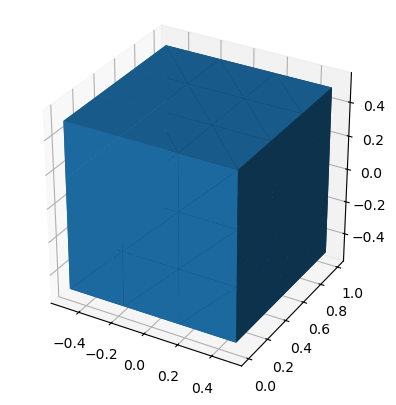

In [30]:
for model_name in set(included_model_names):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    trim = trimesh.load(os.path.join(physion_assets_path, f"all_flex_meshes/{model_name.decode('UTF-8')}.obj",))
    ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)
    set_axes_equal(ax)

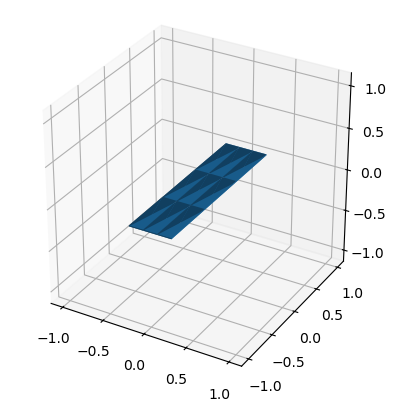

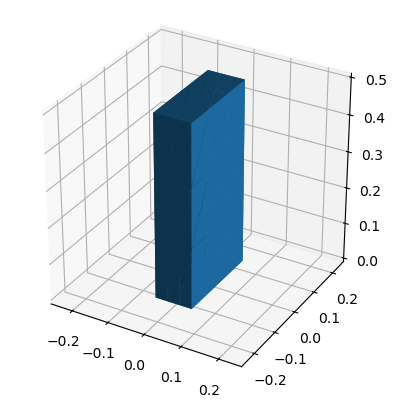

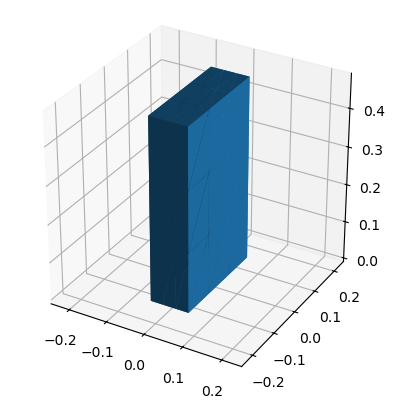

In [31]:
for vertices, faces in object_meshes:
    trim = trimesh.Trimesh(vertices=vertices, faces=faces)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)
    set_axes_equal(ax)


In [32]:
def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    euler[[2,1]] = euler[[1,2]]
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.abs(np.array([x, y, z, w]))

In [33]:
# new_cam_pose = camera_from_position_and_target(jnp.array([-0.8402802,  1.5748523,  1.5009834]), target=jnp.array([0, 0, 0]),)
# new_cam_pose

In [86]:
b3d.rr_init("demo_physion")

In [73]:
all_object_poses = []
all_meshes = []
for idx in range(len(included_model_ids)):
    object_pose = Pose(jnp.asarray(object_initial_positions[idx]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[idx])))
    print(object_pose)
    b3d.rr_log_pose(f"{idx}", object_pose)
    all_object_poses.append(object_pose)

    mesh = trimesh.Trimesh(vertices=object_meshes[idx][0], faces=object_meshes[idx][1])
    mesh = b3d.Mesh.from_trimesh(mesh)
    all_meshes.append(mesh)
    mesh.transform(object_pose).rr_visualize(f"mesh_{idx}")

Pose(position=Array([0.85, 0.  , 0.  ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))
Pose(position=Array([0.25, 0.  , 0.  ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))
Pose(position=Array([-0.25,  0.  ,  0.  ], dtype=float32), quaternion=Array([0.        , 0.10117607, 0.        , 0.9948685 ], dtype=float32))


In [69]:
camera_position =jnp.array([-0.8402802,  1.5748523,  1.5009834])
camera_look_at = jnp.zeros(3)
camera_pose = Pose.from_position_and_target(
    camera_position,
    camera_look_at
)
utils.rr_log_pose("camera_pose", camera_pose)

In [100]:
print(camera_matrix)

[[-8.7257326e-01  0.0000000e+00 -4.8848364e-01 -1.7881393e-07]
 [ 3.2985500e-01  7.3757690e-01 -5.8921647e-01  2.9802322e-08]
 [-3.6029425e-01  6.7526317e-01  6.4358997e-01 -2.3322058e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [140]:
print(camera_pose.as_matrix())

[[-8.8226956e-01 -3.0296654e-01  3.6029434e-01 -8.4028018e-01]
 [-4.7074491e-01  5.6781954e-01 -6.7526335e-01  1.5748523e+00]
 [ 1.4901161e-08 -7.6537091e-01 -6.4358968e-01  1.5009834e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [75]:
scene_mesh = Mesh.transform_and_merge_meshes(all_meshes, all_object_poses)
scene_mesh_in_camera_frame = scene_mesh.transform(camera_pose.inv())
scene_mesh_in_camera_frame.rr_visualize("scene_mesh_in_camera_frame")

In [81]:
depth_arr[0]

<jax.Array float32(1024, 1024) ≈2.6 ±1.0 [≥1.0, ≤5.4] nonzero:1_048_576
  <Arrayviz rendering>
>

In [79]:
renderer = b3d.RendererOriginal(
    width=1024,
    height=1024,
    fx=983.542849009237,
    fy=983.542849009237,
    cx=512.0,
    cy=512.0,
    near=0.1,
    far=100,
)

/home/hlwang_ipe_genjax/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [90]:
rgbd = renderer.render_rgbd_from_mesh(
    scene_mesh_in_camera_frame
)
b3d.rr_log_depth(rgbd[...,3], "depth")
b3d.rr_log_depth(depth_arr[10], "depth/observed")

array([[-8.7257326e-01,  0.0000000e+00, -4.8848364e-01, -1.7881393e-07],
       [ 3.2985500e-01,  7.3757690e-01, -5.8921647e-01,  2.9802322e-08],
       [-3.6029425e-01,  6.7526317e-01,  6.4358997e-01, -2.3322058e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [59]:
for idx in range(len(included_model_ids)):
    object_pose = Pose(jnp.asarray(object_initial_positions[idx]), jnp.asarray(euler_angles_to_quaternion(object_initial_rotations[idx])))
    object_pose_world = camera_pose.inv() @ object_pose
    obj_mesh = Mesh.from_trimesh(trimesh.Trimesh(vertices=object_meshes[idx][0], faces=object_meshes[idx][1]))
    obj_mesh.transform(object_pose_world).rr_visualize(f"{idx}")
utils.rr_log_pose("4", camera_pose.inv() @ camera_pose)

In [139]:
# utils.rr_log_pose("4", object_pose_world)
rr.log("/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN, static=True)  # Set an up-axis


In [63]:
rbb

NameError: name 'rbb' is not defined

In [61]:
utils.rr_log_pose("camera_pose", camera_pose)

camera_pose

Pose(position=Array([-0.8402802,  1.5748523,  1.5009834], dtype=float32), quaternion=Array([ 0.1649275 ,  0.9832801 ,  0.04302335, -0.06409469], dtype=float32))

In [35]:
# # obj_mesh = Mesh.from_obj_file(
# #         os.path.join(physion_assets_path, "all_flex_meshes/cube.obj",))
# obj_mesh = Mesh.from_trimesh(trimesh.Trimesh(vertices=object_meshes[idx][0], faces=object_meshes[idx][1]))
# obj_mesh.transform(object_pose_world).rr_visualize("1")

In [44]:
camera_pose

Pose(position=Array([-0.8402802, -1.5748523, -1.5009834], dtype=float32), quaternion=Array([ 0.06409469, -0.04302335,  0.9832801 ,  0.1649275 ], dtype=float32))

Pose(position=Array([-0.8402802,  1.5748523,  1.5009834], dtype=float32), quaternion=Array([-0.2199436 ,  0.87944275, -0.4095303 ,  0.10242117], dtype=float32))